In [2]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 2. Đọc file csv và gắng index với giá Close
# data = pd.read_csv('/content/drive/MyDrive/Dataset BA/DXG Price History_32019-32024.csv')

dxg_dataset = pd.read_csv('/content/drive/MyDrive/Dataset BA/DXG.csv')
qcg_dataset =  pd.read_csv('/content/drive/MyDrive/Dataset BA/QCG.csv')
vhm_dataset = pd.read_csv('/content/drive/MyDrive/Dataset BA/VHM.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Volume" từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Volume"
# data["Volume"] = data["Volume"].apply(convert_volume_to_number)

dxg_dataset["Volume"] = dxg_dataset["Volume"].apply(convert_volume_to_number)
qcg_dataset["Volume"] = qcg_dataset["Volume"].apply(convert_volume_to_number)
vhm_dataset["Volume"] = vhm_dataset["Volume"].apply(convert_volume_to_number)



# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
# data["Change %"] = data["Change %"].apply(convert_change_to_number)
vhm_dataset["Change %"] = vhm_dataset["Change %"].apply(convert_change_to_number)
dxg_dataset["Change %"] = dxg_dataset["Change %"].apply(convert_change_to_number)
qcg_dataset["Change %"] = qcg_dataset["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị của DXG
dxg_dataset['Close'] = dxg_dataset['Close'].apply(convert_str_to_number)
dxg_dataset['Open'] = dxg_dataset['Open'].apply(convert_str_to_number)
dxg_dataset['High'] = dxg_dataset['High'].apply(convert_str_to_number)
dxg_dataset['Low'] = dxg_dataset['Low'].apply(convert_str_to_number)

# Áp dụng hàm chuyển đổi cho các cột giá trị của VHM
vhm_dataset['Close'] = vhm_dataset['Close'].apply(convert_str_to_number)
vhm_dataset['Open'] = vhm_dataset['Open'].apply(convert_str_to_number)
vhm_dataset['High'] = vhm_dataset['High'].apply(convert_str_to_number)
vhm_dataset['Low'] = vhm_dataset['Low'].apply(convert_str_to_number)

# Áp dụng hàm chuyển đổi cho các cột giá trị của QCG
qcg_dataset['Close'] = qcg_dataset['Close'].apply(convert_str_to_number)
qcg_dataset['Open'] = qcg_dataset['Open'].apply(convert_str_to_number)
qcg_dataset['High'] = qcg_dataset['High'].apply(convert_str_to_number)
qcg_dataset['Low'] = qcg_dataset['Low'].apply(convert_str_to_number)

# df1=data.reset_index()['Close']

vhm_dataset
dxg_dataset
qcg_dataset

,Date,Close,Open,High,Low,Volume,Change %
0,1/3/2024,9160.0,9170.0,9170.0,9070.0,470600,0.0033
1,29/02/2024,9130.0,9200.0,9200.0,9070.0,544100,-0.0076
2,28/02/2024,9200.0,9200.0,9210.0,9040.0,582600,0.0000
3,27/02/2024,9200.0,8920.0,9300.0,8870.0,800300,0.0268
4,26/02/2024,8960.0,8990.0,9000.0,8510.0,444100,-0.0033
...,...,...,...,...,...,...,...
1247,7/3/2019,5370.0,5250.0,5370.0,5200.0,736850,0.0697
1248,6/3/2019,5020.0,4700.0,5020.0,4640.0,2430000,0.0681
1249,5/3/2019,4700.0,4700.0,4750.0,4620.0,1040000,-0.0188
1250,4/3/2019,4790.0,4700.0,4790.0,4600.0,1200000,-0.0021


In [5]:
# Reset Index cho cột close
df1=dxg_dataset.reset_index()['Close']
df2=vhm_dataset.reset_index()['Close']
df3=qcg_dataset.reset_index()['Close']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))
df3=scaler.fit_transform(np.array(df3).reshape(-1,1))

In [7]:
# 4. Chia train test cho DXG
dxg_train_size = int(0.9 * len(df1))
dxg_test_size = int(len(df1) - dxg_train_size)

dxg_train_data = df1[:dxg_train_size]
dxg_test_data = df1[dxg_train_size:dxg_train_size+dxg_test_size]


# 4. Chia train test cho VHM
vhm_train_size = int(0.9 * len(df2))
vhm_test_size = int(len(df1) - vhm_train_size)

vhm_train_data = df2[:vhm_train_size]
vhm_test_data = df2[vhm_train_size:vhm_train_size+vhm_test_size]

# 4. Chia train test cho QCG
qcg_train_size = int(0.9 * len(df3))
qcg_test_size = int(len(df1) - qcg_train_size)

qcg_train_data = df3[:qcg_train_size]
qcg_test_data = df3[qcg_train_size:qcg_train_size+qcg_test_size]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 90
#Create data X, Y for DXG
dxg_X_train, dxg_y_train = create_dataset(dxg_train_data, time_step)
dxg_X_test, dxg_ytest = create_dataset(dxg_test_data, time_step)

#Create data X, Y for VHM
vhm_X_train, vhm_y_train = create_dataset(vhm_train_data, time_step)
vhm_X_test, vhm_ytest = create_dataset(vhm_test_data, time_step)

#Create data X, Y for DXG
qcg_X_train, qcg_y_train = create_dataset(qcg_train_data, time_step)
qcg_X_test, qcg_ytest = create_dataset(qcg_test_data, time_step)

In [10]:
# 7. Reshape input of DXG to be [samples, time steps, features] which is required for LSTM
dxg_X_train =dxg_X_train.reshape(dxg_X_train.shape[0],dxg_X_train.shape[1] , 1)
dxg_X_test = dxg_X_test.reshape(dxg_X_test.shape[0],dxg_X_test.shape[1] , 1)


# 7. Reshape input of VHM to be [samples, time steps, features] which is required for LSTM
vhm_X_train =vhm_X_train.reshape(vhm_X_train.shape[0],vhm_X_train.shape[1] , 1)
vhm_X_test = vhm_X_test.reshape(vhm_X_test.shape[0],vhm_X_test.shape[1] , 1)


# 7. Reshape input of QCG to be [samples, time steps, features] which is required for LSTM
qcg_X_train =qcg_X_train.reshape(qcg_X_train.shape[0],qcg_X_train.shape[1] , 1)
qcg_X_test = qcg_X_test.reshape(qcg_X_test.shape[0],qcg_X_test.shape[1] , 1)


In [11]:
#8. Define LSTM Model

def build_tcn_model(timesteps):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

dxg_model = build_tcn_model(time_step)
vhm_model = build_tcn_model(time_step)
qcg_model = build_tcn_model(time_step)
# model.summary()

In [12]:
print("DXG")
dxg_model.fit(dxg_X_train,dxg_y_train,validation_data=(dxg_X_test,dxg_ytest),epochs=100,batch_size=64,verbose=1)
print("VHM")
vhm_model.fit(vhm_X_train,vhm_y_train,validation_data=(vhm_X_test,vhm_ytest),epochs=100,batch_size=64,verbose=1)
print("QCG")
qcg_model.fit(qcg_X_train,qcg_y_train,validation_data=(qcg_X_test,qcg_ytest),epochs=100,batch_size=64,verbose=1)

DXG
Epoch 1/100
17/17 [==============================] - 11s 297ms/step - loss: 0.0320 - val_loss: 9.1490e-04
Epoch 2/100
17/17 [==============================] - 2s 136ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 3/100
17/17 [==============================] - 2s 136ms/step - loss: 0.0034 - val_loss: 7.8274e-04
Epoch 4/100
17/17 [==============================] - 2s 138ms/step - loss: 0.0031 - val_loss: 7.6972e-04
Epoch 5/100
17/17 [==============================] - 3s 173ms/step - loss: 0.0025 - val_loss: 7.5519e-04
Epoch 6/100
17/17 [==============================] - 4s 224ms/step - loss: 0.0023 - val_loss: 9.4626e-04
Epoch 7/100
17/17 [==============================] - 2s 136ms/step - loss: 0.0024 - val_loss: 6.1005e-04
Epoch 8/100
17/17 [==============================] - 2s 135ms/step - loss: 0.0020 - val_loss: 6.5538e-04
Epoch 9/100
17/17 [==============================] - 2s 136ms/step - loss: 0.0020 - val_loss: 6.4276e-04
Epoch 10/100
17/17 [==============================] - 

In [13]:
# 10. Dự báo dữ liệu test cho DXG
print("DXG Pred")
dxg_y_pred=dxg_model.predict(dxg_X_test)

dxg_y_pred_new = scaler.inverse_transform(dxg_y_pred.reshape(1, -1))
dxg_y_test_new = scaler.inverse_transform(np.array([dxg_ytest], dtype=np.float32))

# 10. Dự báo dữ liệu test cho VHM
print("VHM Pred")
vhm_y_pred=vhm_model.predict(vhm_X_test)

vhm_y_pred_new = scaler.inverse_transform(vhm_y_pred.reshape(1, -1))
vhm_y_test_new = scaler.inverse_transform(np.array([vhm_ytest], dtype=np.float32))

# 10. Dự báo dữ liệu test cho QCG
print("QCG Pred")
qcg_y_pred=qcg_model.predict(qcg_X_test)

qcg_y_pred_new = scaler.inverse_transform(qcg_y_pred.reshape(1, -1))
qcg_y_test_new = scaler.inverse_transform(np.array([qcg_ytest], dtype=np.float32))

DXG Pred
2/2 [==============================] - 2s 24ms/step
VHM Pred
2/2 [==============================] - 2s 20ms/step
QCG Pred
2/2 [==============================] - 1s 21ms/step


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test của DXG
dxg_test_score_rmse = np.sqrt(mean_squared_error(dxg_y_test_new, dxg_y_pred_new))
dxg_test_score_mape = mean_absolute_percentage_error(dxg_y_test_new, dxg_y_pred_new) * 100
dxg_test_score_mda = calculate_mda(dxg_y_test_new, dxg_y_pred_new)

print('RMSE trên tập test của DXG là:', dxg_test_score_rmse)
print('MAPE trên tập test của DXG là:', dxg_test_score_mape, '%')
print('MDA trên tập test của DXG là:', dxg_test_score_mda, '%')

# Tính toán RMSE, MAE và MAPE trên tập test của VHM
vhm_test_score_rmse = np.sqrt(mean_squared_error(vhm_y_test_new, vhm_y_pred_new))
vhm_test_score_mape = mean_absolute_percentage_error(vhm_y_test_new, vhm_y_pred_new) * 100
vhm_test_score_mda = calculate_mda(vhm_y_test_new, vhm_y_pred_new)

print('RMSE trên tập test của VHM là:', vhm_test_score_rmse)
print('MAPE trên tập test của VHM là:', vhm_test_score_mape, '%')
print('MDA trên tập test của VHM là:', vhm_test_score_mda, '%')

# Tính toán RMSE, MAE và MAPE trên tập test của QCG
qcg_test_score_rmse = np.sqrt(mean_squared_error(qcg_y_test_new, qcg_y_pred_new))
qcg_test_score_mape = mean_absolute_percentage_error(qcg_y_test_new, qcg_y_pred_new) * 100
qcg_test_score_mda = calculate_mda(qcg_y_test_new, qcg_y_pred_new)

print('RMSE trên tập test của QCG là:', qcg_test_score_rmse)
print('MAPE trên tập test của QCG là:', qcg_test_score_mape, '%')
print('MDA trên tập test của QCG là:', qcg_test_score_mda, '%')

RMSE trên tập test của DXG là: 205.6617
MAPE trên tập test của DXG là: 2.0476268604397774 %
MDA trên tập test của DXG là: 50.0 %
RMSE trên tập test của VHM là: 453.6481
MAPE trên tập test của VHM là: 2.435454912483692 %
MDA trên tập test của VHM là: 41.17647058823529 %
RMSE trên tập test của QCG là: 309.74008
MAPE trên tập test của QCG là: 4.559352248907089 %
MDA trên tập test của QCG là: 58.82352941176471 %


In [15]:
# 13. Dự báo 90 ngày tiếp theo cho tập DXG
dxg_x_input = dxg_test_data[-time_step:].reshape(1, -1, 1)  # Lấy dữ liệu cuối cùng trong tập validation, reshape để phù hợp với input của mô hình
dxg_temp_input = list(dxg_x_input.flatten())[:time_step]  # Chuyển dữ liệu thành danh sách và chỉ sử dụng số lượng phần tử bằng số time step

from numpy import array

dxg_lst_output = []
dxg_n_steps = time_step

# Dự đoán giá cho 90 ngày tiếp theo
for i in range(90):
    dxg_x_input = array(dxg_temp_input)  # Sử dụng số lượng phần tử bằng số time step
    print("{} day input {}".format(i,dxg_x_input))
    dxg_x_input = dxg_x_input.reshape((1, dxg_n_steps, 1))  # Reshape lại để phù hợp với input của mô hình
    dxg_yhat = dxg_model.predict(dxg_x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
    print("{} day output {}".format(i,dxg_yhat))
    dxg_temp_input.extend(dxg_yhat[0].tolist())  # Thêm dự đoán vào danh sách
    dxg_temp_input = dxg_temp_input[1:]  # Loại bỏ phần tử đầu tiên
    dxg_lst_output.extend(dxg_yhat.tolist())  # Thêm dự đoán vào danh sách kết quả

print(dxg_lst_output)


0 day input [0.14255865 0.14768476 0.14255865 0.14426819 0.14512045 0.14341342
 0.14768476 0.15195609 0.15024906 0.15110132 0.15110132 0.15366563
 0.15452039 0.15793696 0.14853952 0.14255865 0.13914208 0.13743255
 0.14426819 0.14597522 0.14768476 0.14939429 0.14853952 0.14341342
 0.13743255 0.13914208 0.13572302 0.13401598 0.14426819 0.15537516
 0.15537516 0.15537516 0.15793696 0.16050126 0.1647726  0.15622743
 0.15622743 0.15452039 0.15452039 0.15879173 0.16135353 0.15622743
 0.1596465  0.16050126 0.15622743 0.13743255 0.15110132 0.15879173
 0.18271271 0.19211265 0.19552922 0.19552922 0.19894579 0.19723875
 0.20492666 0.20749096 0.19211265 0.20749096 0.21090753 0.21603363
 0.21517886 0.21261706 0.2194527  0.2271406  0.22970491 0.2168884
 0.2143266  0.21347183 0.21517886 0.21261706 0.21603363 0.21603363
 0.20492666 0.19980055 0.2194527  0.21603363 0.23226671 0.23312147
 0.24679275 0.24508321 0.25191885 0.25020932 0.25362589 0.25448065
 0.24422845 0.25875199 0.27327803 0.2690042  0.2766

In [16]:
# 13. Dự báo 90 ngày tiếp theo cho tập VHM
vhm_x_input = vhm_test_data[-time_step:].reshape(1, -1, 1)  # Lấy dữ liệu cuối cùng trong tập validation, reshape để phù hợp với input của mô hình
vhm_temp_input = list(vhm_x_input.flatten())[:time_step]  # Chuyển dữ liệu thành danh sách và chỉ sử dụng số lượng phần tử bằng số time step

from numpy import array

vhm_lst_output = []
vhm_n_steps = time_step

# Dự đoán giá cho 90 ngày tiếp theo
for i in range(90):
    vhm_x_input = array(vhm_temp_input)  # Sử dụng số lượng phần tử bằng số time step
    print("{} day input {}".format(i,vhm_x_input))
    vhm_x_input = vhm_x_input.reshape((1, vhm_n_steps, 1))  # Reshape lại để phù hợp với input của mô hình
    vhm_yhat = vhm_model.predict(vhm_x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
    print("{} day output {}".format(i,vhm_yhat))
    vhm_temp_input.extend(vhm_yhat[0].tolist())  # Thêm dự đoán vào danh sách
    vhm_temp_input = vhm_temp_input[1:]  # Loại bỏ phần tử đầu tiên
    vhm_lst_output.extend(vhm_yhat.tolist())  # Thêm dự đoán vào danh sách kết quả

print(vhm_lst_output)


0 day input [0.48251512 0.47801957 0.47652769 0.52138367 0.50644494 0.46156906
 0.44810232 0.44661044 0.42118873 0.39425525 0.41669319 0.4241725
 0.4241725  0.40921388 0.40772199 0.40324634 0.40173456 0.40173456
 0.43015993 0.43165181 0.43165181 0.46007718 0.46156906 0.46455283
 0.43614736 0.44062301 0.44062301 0.44062301 0.46156906 0.47054026
 0.48549889 0.484007   0.49745385 0.49896563 0.52886299 0.52886299
 0.53186665 0.53335853 0.53186665 0.5363423  0.52138367 0.50644494
 0.50644494 0.49148631 0.49896563 0.51541614 0.54980904 0.56625955
 0.5872056  0.60216423 0.61113542 0.58420194 0.57672263 0.56625955
 0.58121817 0.56625955 0.56625955 0.5782344  0.5961768  0.6305697
 0.63355347 0.61861474 0.63804901 0.65002387 0.62010662 0.61113542
 0.61113542 0.61411919 0.61710296 0.60365611 0.62758593 0.58271006
 0.57972629 0.56625955 0.59766868 0.55430458 0.61411919 0.64103278
 0.64552833 0.6305697  0.64103278 0.64103278 0.61561108 0.58121817
 0.60365611 0.61113542 0.60813176 0.5961768  0.62907

In [17]:
# 13. Dự báo 90 ngày tiếp theo cho tập QCG
qcg_x_input = qcg_test_data[-time_step:].reshape(1, -1, 1)  # Lấy dữ liệu cuối cùng trong tập validation, reshape để phù hợp với input của mô hình
qcg_temp_input = list(qcg_x_input.flatten())[:time_step]  # Chuyển dữ liệu thành danh sách và chỉ sử dụng số lượng phần tử bằng số time step

from numpy import array

qcg_lst_output = []
qcg_n_steps = time_step

# Dự đoán giá cho 90 ngày tiếp theo
for i in range(90):
    qcg_x_input = array(qcg_temp_input)  # Sử dụng số lượng phần tử bằng số time step
    print("{} day input {}".format(i,qcg_x_input))
    qcg_x_input = qcg_x_input.reshape((1, qcg_n_steps, 1))  # Reshape lại để phù hợp với input của mô hình
    qcg_yhat = qcg_model.predict(qcg_x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
    print("{} day output {}".format(i,qcg_yhat))
    qcg_temp_input.extend(qcg_yhat[0].tolist())  # Thêm dự đoán vào danh sách
    qcg_temp_input = qcg_temp_input[1:]  # Loại bỏ phần tử đầu tiên
    qcg_lst_output.extend(qcg_yhat.tolist())  # Thêm dự đoán vào danh sách kết quả

print(qcg_lst_output)


0 day input [0.05432596 0.05331992 0.05331992 0.05231388 0.0583501  0.05382294
 0.05885312 0.06287726 0.06086519 0.06438632 0.0694165  0.07243461
 0.07394366 0.07645875 0.07847082 0.07696177 0.07696177 0.07746479
 0.07947686 0.08350101 0.08702213 0.08400402 0.08802817 0.08702213
 0.07947686 0.07947686 0.08249497 0.09104628 0.09205231 0.09205231
 0.0915493  0.0915493  0.0915493  0.09205231 0.08903421 0.09557344
 0.09959759 0.10211268 0.10311871 0.10462777 0.09959759 0.08249497
 0.08249497 0.08148893 0.08199195 0.08953722 0.09406439 0.08953722
 0.09708249 0.09959759 0.09657948 0.10211268 0.10462777 0.10714286
 0.09808853 0.10965795 0.09909457 0.11217304 0.13279678 0.15492958
 0.15291751 0.13229376 0.13480885 0.12273642 0.10412475 0.10412475
 0.09959759 0.10865191 0.11016097 0.10412475 0.09708249 0.09557344
 0.09607646 0.09507042 0.09909457 0.09909457 0.09959759 0.1001006
 0.11468813 0.13028169 0.13832998 0.13933602 0.13933602 0.13430584
 0.11720322 0.10311871 0.08551308 0.0694165  0.0739

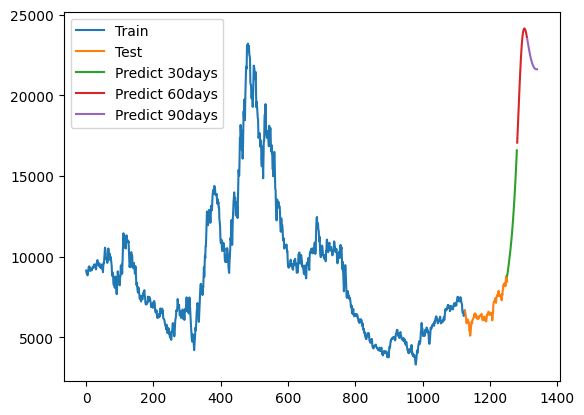

In [18]:
# 14.Vẽ hình DXG
dxg_train_data_index = pd.RangeIndex(start=0, stop=dxg_train_size, step=1)
plt.plot(scaler.inverse_transform(dxg_train_data))

dxg_test_data_index = pd.RangeIndex(start=dxg_train_size, stop=dxg_train_size+dxg_test_size, step=1)
plt.plot(dxg_test_data_index,scaler.inverse_transform(dxg_test_data))

# dxg_test_data_index = pd.RangeIndex(start=dxg_train_size+31, stop=dxg_train_size+dxg_test_size, step=1)
# plt.plot(dxg_test_data_index,scaler.inverse_transform(dxg_y_pred))

predict_30_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_30_data_index,scaler.inverse_transform(dxg_lst_output[:30]))

predict_60_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_60_data_index,scaler.inverse_transform(dxg_lst_output[30:60]))

predict_90_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_90_data_index,scaler.inverse_transform(dxg_lst_output[60:90]))

plt.legend(['Train','Test','Predict 30days' ,'Predict 60days' ,'Predict 90days'])
plt.show()

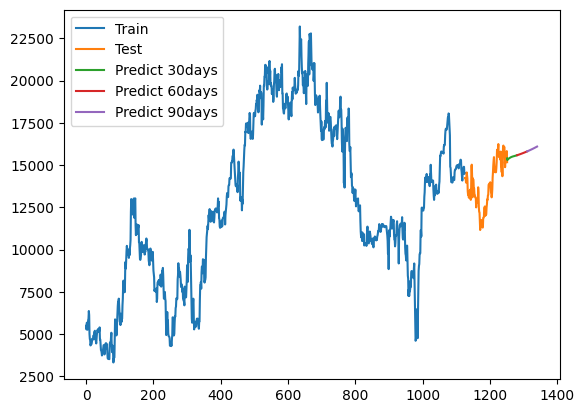

In [19]:
# 14.Vẽ hình VHM
vhm_train_data_index = pd.RangeIndex(start=0, stop=vhm_train_size, step=1)
plt.plot(scaler.inverse_transform(vhm_train_data))

vhm_test_data_index = pd.RangeIndex(start=vhm_train_size, stop=vhm_train_size+vhm_test_size, step=1)
plt.plot(vhm_test_data_index,scaler.inverse_transform(vhm_test_data))

# vhm_test_data_index = pd.RangeIndex(start=vhm_train_size+31, stop=vhm_train_size+vhm_test_size, step=1)
# plt.plot(vhm_test_data_index,scaler.inverse_transform(vhm_y_pred))

predict_30_data_index = pd.RangeIndex(start=len(df2)-1, stop=len(df2)+29, step=1)
plt.plot(predict_30_data_index,scaler.inverse_transform(vhm_lst_output[:30]))

predict_60_data_index = pd.RangeIndex(start=len(df2)+29, stop=len(df2)+59, step=1)
plt.plot(predict_60_data_index,scaler.inverse_transform(vhm_lst_output[30:60]))

predict_90_data_index = pd.RangeIndex(start=len(df2)+59, stop=len(df2)+89, step=1)
plt.plot(predict_90_data_index,scaler.inverse_transform(vhm_lst_output[60:90]))

plt.legend(['Train','Test','Predict 30days' ,'Predict 60days' ,'Predict 90days'])
plt.show()

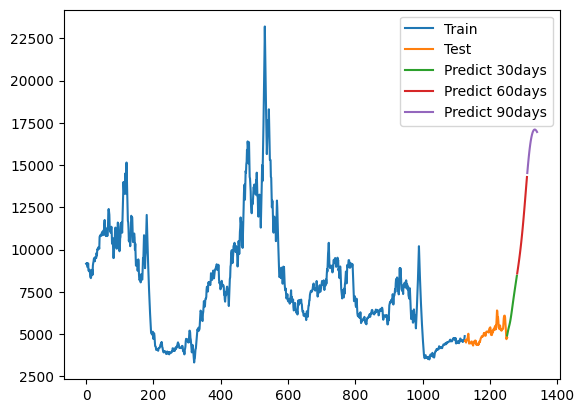

In [20]:
# 14.Vẽ hình QCG
qcg_train_data_index = pd.RangeIndex(start=0, stop=qcg_train_size, step=1)
plt.plot(scaler.inverse_transform(qcg_train_data))

qcg_test_data_index = pd.RangeIndex(start=qcg_train_size, stop=qcg_train_size+qcg_test_size, step=1)
plt.plot(qcg_test_data_index,scaler.inverse_transform(qcg_test_data))

# qcg_test_data_index = pd.RangeIndex(start=qcg_train_size+31, stop=qcg_train_size+qcg_test_size, step=1)
# plt.plot(qcg_test_data_index,scaler.inverse_transform(qcg_y_pred))

predict_30_data_index = pd.RangeIndex(start=len(df3)-1, stop=len(df3)+29, step=1)
plt.plot(predict_30_data_index,scaler.inverse_transform(qcg_lst_output[:30]))

predict_60_data_index = pd.RangeIndex(start=len(df3)+29, stop=len(df3)+59, step=1)
plt.plot(predict_60_data_index,scaler.inverse_transform(qcg_lst_output[30:60]))

predict_90_data_index = pd.RangeIndex(start=len(df3)+59, stop=len(df3)+89, step=1)
plt.plot(predict_90_data_index,scaler.inverse_transform(qcg_lst_output[60:90]))

plt.legend(['Train','Test','Predict 30days' ,'Predict 60days' ,'Predict 90days'])
plt.show()